In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


C:\Users\singh\AppData\Local\Temp\ipykernel_27344\1341130196.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2022-01-01', periods=n_points, freq='H')


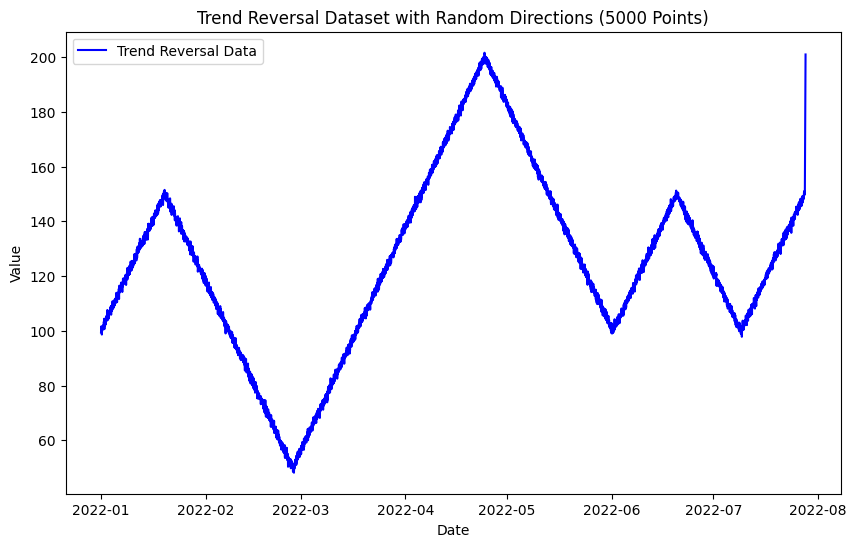

                 Date  TrendReversal
0 2022-01-01 00:00:00      99.449766
1 2022-01-01 01:00:00     100.625808
2 2022-01-01 02:00:00     100.694611
3 2022-01-01 03:00:00     101.699576
4 2022-01-01 04:00:00      99.524674


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate 5000 points for the trend reversal dataset
n_points = 5000
reversals = 10  # Number of trend reversals

# Calculate points per segment
points_per_segment = n_points // (reversals + 1)

# Generate the trend reversals with random directions
trend_data = []

current_value = 100  # Starting value

for i in range(reversals + 1):
    # Randomly choose between an upward or downward trend
    direction = np.random.choice(['up', 'down'])
    
    if direction == 'up':
        trend = np.linspace(current_value, current_value + 50, points_per_segment) + np.random.normal(0, 1, points_per_segment)
        current_value += 50  # Update current value for next segment
    else:
        trend = np.linspace(current_value, current_value - 50, points_per_segment) + np.random.normal(0, 1, points_per_segment)
        current_value -= 50  # Update current value for next segment

    trend_data.extend(trend)

# Handle any remaining points (in case n_points is not divisible by number of segments)
remaining_points = n_points - len(trend_data)
if remaining_points > 0:
    final_trend = np.linspace(trend_data[-1], trend_data[-1] + 50, remaining_points) + np.random.normal(0, 1, remaining_points)
    trend_data.extend(final_trend)

# Convert to numpy array
trend_data = np.array(trend_data)

# Create a date range for the dataset
date_range = pd.date_range(start='2022-01-01', periods=n_points, freq='H')

# Create DataFrame
df = pd.DataFrame({'Date': date_range, 'TrendReversal': trend_data})

# Plot the generated trend reversal data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['TrendReversal'], color='blue', label='Trend Reversal Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trend Reversal Dataset with Random Directions (5000 Points)')
plt.legend()
plt.show()

# Display the first few rows of the DataFrame
print(df.head())


In [3]:
# Do adf test for adj close
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['TrendReversal'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 0.184179
p-value: 0.971360


In [4]:
# Difference trend reversal data
df['TrendReversal'] = df['TrendReversal'].diff().fillna(0)

In [5]:
# Do adf test for adj close
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['TrendReversal'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.396558
p-value: 0.910672


In [6]:
df['TrendReversal'] = df['TrendReversal'].diff().fillna(0)

In [7]:
# Do adf test for adj close
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['TrendReversal'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -16.680900
p-value: 0.000000


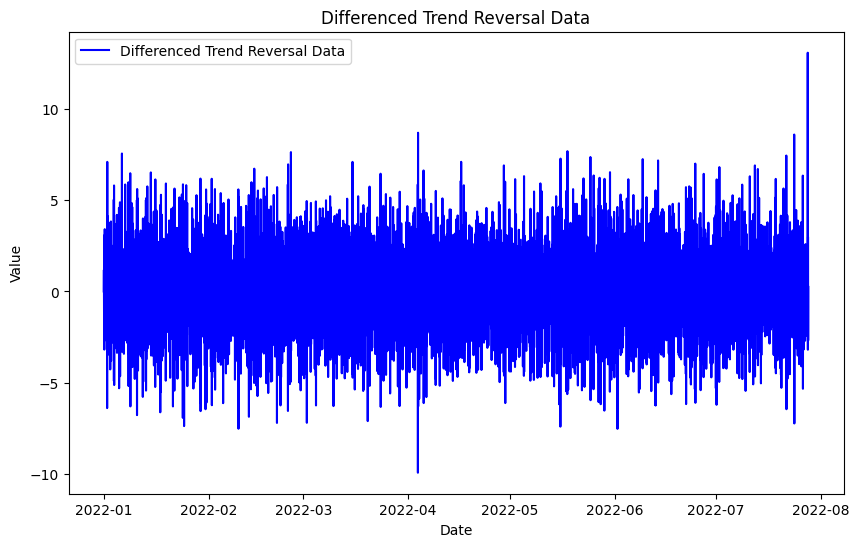

In [8]:
# Plot differenced data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['TrendReversal'], color='blue', label='Differenced Trend Reversal Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Differenced Trend Reversal Data')
plt.legend()
plt.show()

In [9]:
# diff_data equals numpy df['TrendReversal]
diff_data = df['TrendReversal'].to_numpy()

In [10]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler


def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

def train_validate_test_split(data, train_size=0.7, val_size=0.15):
    n = len(data)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    return train_data, val_data, test_data

train_data, val_data, test_data = train_validate_test_split(diff_data)

scaler = MinMaxScaler()
scaler.fit(train_data.reshape(-1, 1))

train_data = scaler.transform(train_data.reshape(-1, 1)).flatten()
val_data = scaler.transform(val_data.reshape(-1, 1)).flatten()
test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()


In [11]:

sequence_length = 50  # Example sequence length

X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

X_train = X_train.reshape(-1, sequence_length, 1)
X_val = X_val.reshape(-1, sequence_length, 1)
X_test = X_test.reshape(-1, sequence_length, 1)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [12]:
import torch
import torch.nn as nn
from models import ElmanRNN

input_size = 1
hidden_size = 64  # Adjust as needed
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 20
batch_size = 64


In [13]:

from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [14]:
model = ElmanRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_losses.append(loss.item())
        model.train()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {np.mean(val_losses):.4f}')

In [16]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/20, Train Loss: 0.0663, Val Loss: 0.0199
Epoch 2/20, Train Loss: 0.0189, Val Loss: 0.0185
Epoch 3/20, Train Loss: 0.0178, Val Loss: 0.0173
Epoch 4/20, Train Loss: 0.0168, Val Loss: 0.0162
Epoch 5/20, Train Loss: 0.0157, Val Loss: 0.0151
Epoch 6/20, Train Loss: 0.0146, Val Loss: 0.0140
Epoch 7/20, Train Loss: 0.0135, Val Loss: 0.0129
Epoch 8/20, Train Loss: 0.0124, Val Loss: 0.0118
Epoch 9/20, Train Loss: 0.0112, Val Loss: 0.0107
Epoch 10/20, Train Loss: 0.0101, Val Loss: 0.0095
Epoch 11/20, Train Loss: 0.0091, Val Loss: 0.0085
Epoch 12/20, Train Loss: 0.0081, Val Loss: 0.0076
Epoch 13/20, Train Loss: 0.0072, Val Loss: 0.0069
Epoch 14/20, Train Loss: 0.0067, Val Loss: 0.0071
Epoch 15/20, Train Loss: 0.0062, Val Loss: 0.0059
Epoch 16/20, Train Loss: 0.0065, Val Loss: 0.0058
Epoch 17/20, Train Loss: 0.0057, Val Loss: 0.0057
Epoch 18/20, Train Loss: 0.0056, Val Loss: 0.0054
Epoch 19/20, Train Loss: 0.0090, Val Loss: 0.0088
Epoch 20/20, Train Loss: 0.0070, Val Loss: 0.0062


In [17]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            output = model(X_batch)
            predictions.extend(output.numpy())
            actuals.extend(y_batch.numpy())
    return np.array(predictions), np.array(actuals)

predictions, actuals = predict(model, test_loader)

In [18]:
# Reshape for inverse transform
predictions = predictions.reshape(-1, 1)
actuals = actuals.reshape(-1, 1)

predictions_inv = scaler.inverse_transform(predictions)
actuals_inv = scaler.inverse_transform(actuals)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals_inv, predictions_inv)
mae = mean_absolute_error(actuals_inv, predictions_inv)
print(f'Test MSE: {mse:.4f}, Test MAE: {mae:.4f}')


Test MSE: 2.4676, Test MAE: 1.1699


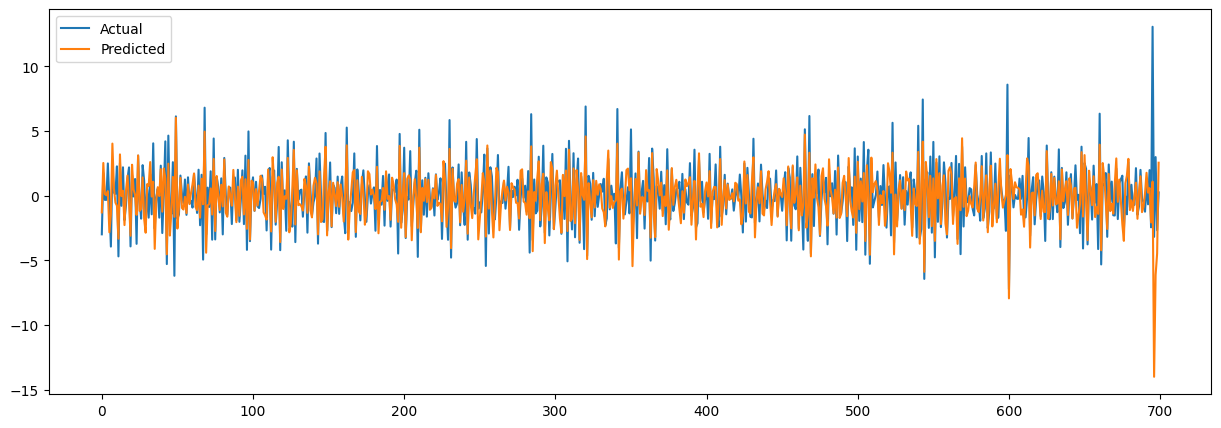

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(actuals_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.show()